In [1]:
import os

os.chdir("/Users/lcn1/Desktop/Athese/code/RHM_Cagnetta/hierarchy-learning-master")

In [2]:
from functools import partial

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
SMALL_SIZE = 24

plt.rc('axes', titlesize=SMALL_SIZE, labelsize=SMALL_SIZE)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE + 5)  # fontsize of th

from analysis.load_and_plot import load_data, plot_all_train_losses, plot_all_test_errors, setup_colors, smoothen, \
    compare_rows

## Get and prepare data

In [8]:
encoder_runs, eval_runs = load_data("/Volumes/lcncluster/delrocq/code/RHM_Cagnetta/logs/rd", rec=False)
clapp_runs = encoder_runs[encoder_runs["name"].apply(lambda x: "orig" not in x)]
clapp_evals = eval_runs[eval_runs.encoder_run.isin(encoder_runs["name"])]

## Basic plotting

In [30]:
enc_of_interest = clapp_runs   #encoder_runs#[encoder_runs["name"].apply(lambda x: len(x) > 6)]
ev_of_interest = clapp_evals   #eval_runs#[eval_runs.encoder_run.apply(lambda x: len(x) > 6)]

(<Figure size 1500x1000 with 1 Axes>,
 <Axes: xlabel='Epochs', ylabel='Train loss'>)

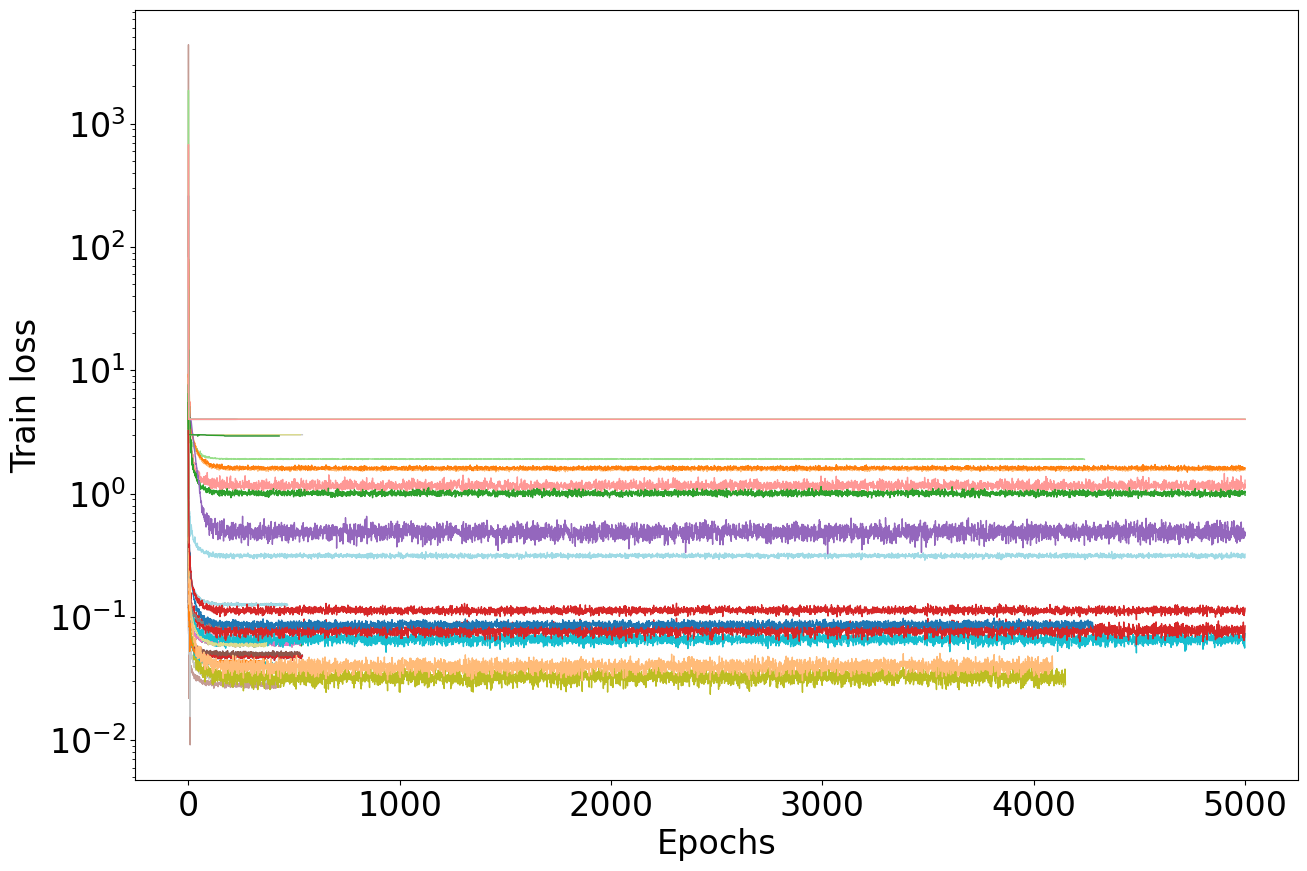

In [10]:
col_fun = setup_colors(enc_of_interest)
plot_all_train_losses(enc_of_interest, col_fun=col_fun, smooth=1, legend=False)

(<Figure size 1500x1000 with 1 Axes>,
 <Axes: xlabel='Epochs', ylabel='Train loss'>)

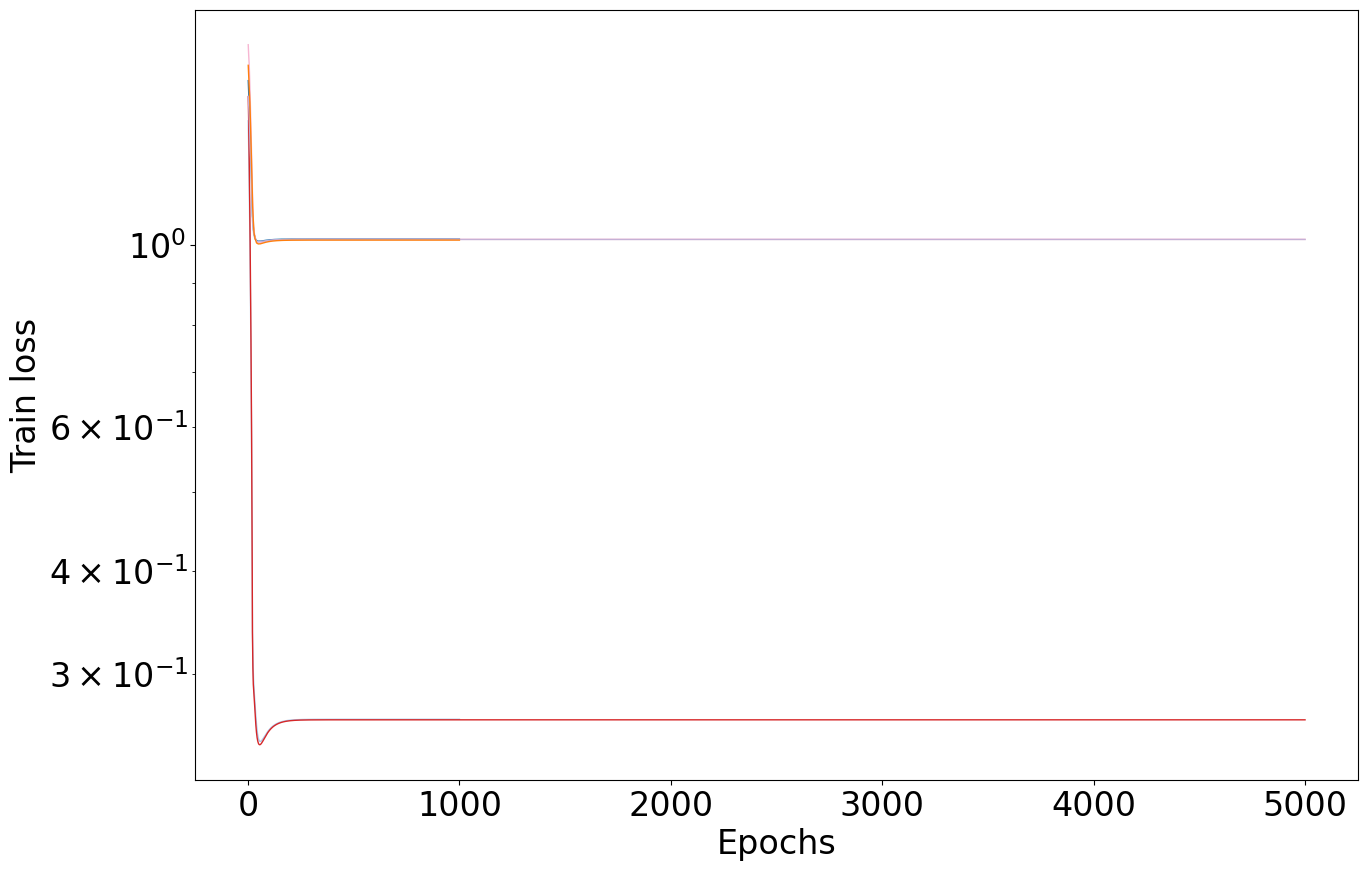

In [20]:
plot_all_train_losses(ev_of_interest, col_fun=col_fun, legend=False)

(<Figure size 1500x1000 with 1 Axes>,
 <Axes: xlabel='Epochs', ylabel='Test error (%)'>)

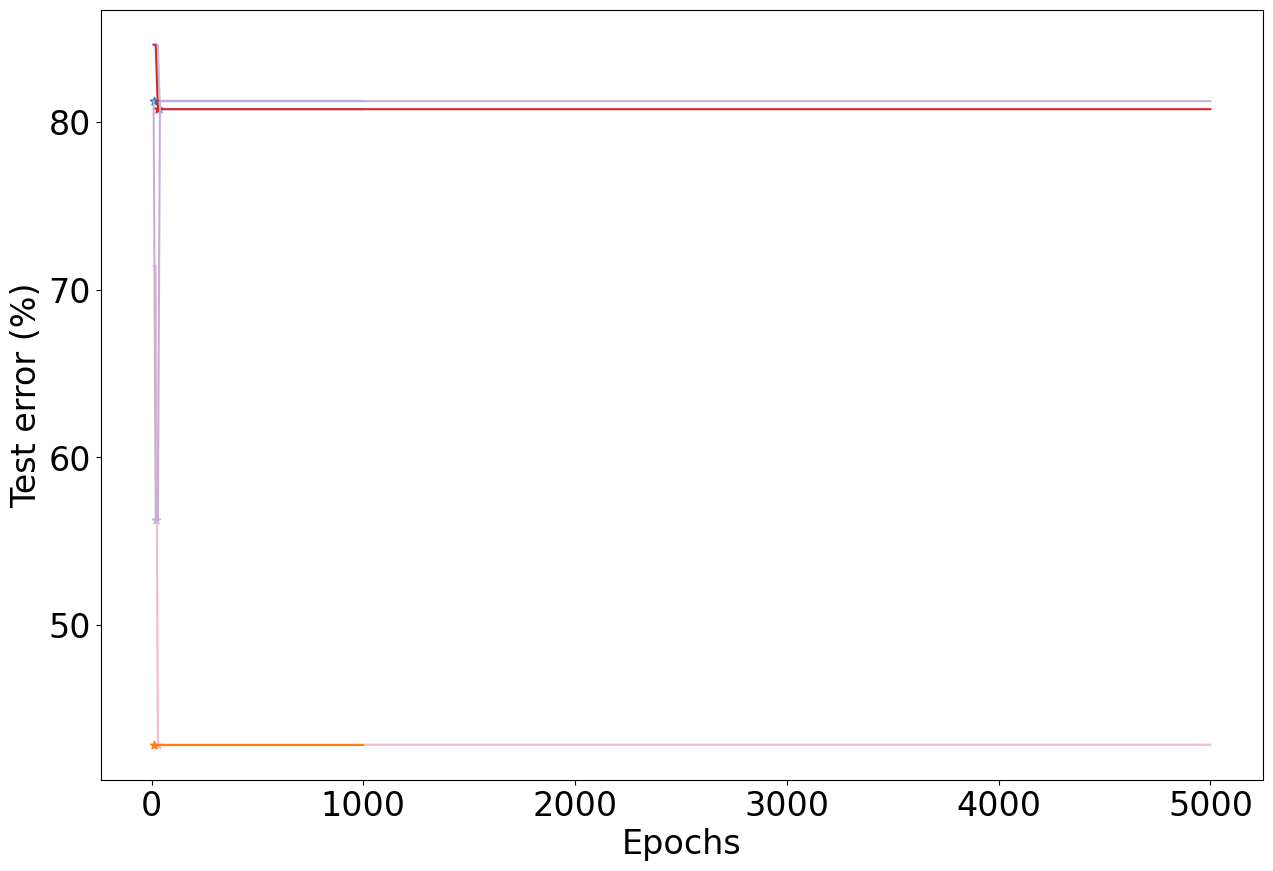

In [21]:
plot_all_test_errors(ev_of_interest, col_fun=col_fun, legend=False)

## Analyze what are better hyperparameters

In [ ]:
encoder_runs[["m", "num_layers", "optim", "lr","scheduler", "momentum", "weight_decay", "width", "ptr", "first_under_4", "zero_loss_threshold", "final_loss"]].sort_values("final_loss")

In [ ]:
stuck = encoder_runs[encoder_runs.first_under_4 > 5000]
stuck[["m", "num_layers", "optim", "lr","scheduler", "momentum", "weight_decay", "width", "ptr"]]#.apply(lambda x: x.unique(), axis=0)

In [ ]:
lates = encoder_runs[(encoder_runs.first_under_4 >= 20) & (encoder_runs.first_under_4 < 5000)]
f, a = plot_all_train_losses(lates, col_fun=setup_colors(lates), smooth=10)
# a.set_xlim(-1, 200)

In [ ]:
lates[["m", "num_layers", "optim", "lr","scheduler", "momentum", "weight_decay", "width", "ptr"]]

In [ ]:
earlies = encoder_runs[encoder_runs.first_under_4 < 20]
f, a = plot_all_train_losses(earlies, col_fun=setup_colors(earlies), smooth=10)
# a.set_xlim(-1, 200)

In [ ]:
earlies[["m", "num_layers", "optim", "lr","scheduler", "momentum", "weight_decay", "width", "ptr"]]

In [ ]:
earlies[earlies.optim=="sgd"].lr.unique()

In [ ]:
encoder_runs[encoder_runs.optim=="sgd"].lr.unique()

In [ ]:
def plot_single_param_effect(param, df, other_params=None, scale=None, crit="first_under_4"):
    if df[param].nunique() < 2:
        print("No values for ", param)
        return
    print(param)
    fig, ax = plt.subplots(figsize=(10,8))
    try:
        ax.scatter(df[param], df[crit], color="gray")
        done = None
    except:
        done = []
        vals = []
        for x in df[param]:
            if x not in done:
                done.append(x)
            vals.append(done.index(x))
        ax.scatter(vals, df[crit], color="gray")
        ax.set_xticks(list(range(len(done))))
        ax.set_xticklabels(done)
        print(done, vals)
    ax.set_xlabel(param)
    ax.set_ylabel(crit)

    if other_params is None:
        return
    # Now, try to draw a link between those that have only that param different
    if param in other_params:
        other_params = [x for x in other_params if x !=param]
    dfp = df[other_params]
    # could be optimized:
    for i, row1 in dfp.iterrows():
        for j, row2 in dfp.iterrows():
            if i<j and row1.equals(row2):
                vals = [df.loc[i][param], df.loc[j][param]]
                if done is not None:
                    vals = [done.index(x) for x in vals]
                if scale=='log':
                    vals = [x if x != 0 else 3.5e-4 for x in vals ]
                ax.plot(vals, [df.loc[i][crit], df.loc[j][crit]], color='k', alpha=0.1)
    # ax.set_xscale('log')


def plot_each_param_effect(params, controls, df, **kwargs):
    for param in params:
        plot_single_param_effect(param, df, params+controls, **kwargs)

In [ ]:
# encoder_runs["relative_width"] = encoder_runs.apply(lambda x: x.width / (x.num_features**2), axis=1)

In [ ]:
plot_each_param_effect(["optim", "lr","scheduler", "momentum", "weight_decay", #"width",
 "relative_width", "ptr"], ["m", "num_layers"], encoder_runs, scale=None)

eval_runs.epoch_loaded.unique()

## Find which results are good

In [ ]:
good_evals = eval_runs[(eval_runs.best_acc >70) & ~(eval_runs["name"].apply(lambda x: "orig" in x))]
good_encs = encoder_runs[encoder_runs["name"].isin(good_evals.encoder_run.unique())]

In [ ]:
good_evals = eval_runs[eval_runs["name"].apply(lambda x: "clapp_big_" in x)]
good_encs = encoder_runs[encoder_runs["name"].isin(good_evals.encoder_run.unique())]

In [ ]:
def col_fun_big_clfe(row):
    cols = [f"C{i}" for i in range(10)]
    nb = eval(row["name"].split("_clf")[0][10:])
    c = cols[nb]
    if "clfe" in row["name"]:
        ls = "--"
    else:
        ls = "-"
    alphas = {2: 0.2, 4: 0.5, 6: 0.7, 8: 0.8, 12: 1}
    a = alphas[row.m]
    return c, a, ls

In [ ]:
col_fun = col_fun_big_clfe# setup_colors(good_encs)
plot_all_train_losses(good_encs, col_fun=col_fun, smooth=1)

In [ ]:
plot_all_train_losses(good_evals, col_fun=col_fun)

In [ ]:
f, a = plot_all_test_errors(good_evals, col_fun=col_fun)
# a.set_ylim(-1, 8)

In [ ]:
good_evals[["encoder_run", "name", "best_acc", "m", "num_layers", "optim", "lr","scheduler", "momentum", "weight_decay", "width", "ptr", "zero_loss_threshold"]].sort_values("encoder_run")

In [ ]:
good_encs[["m", "num_layers", "optim", "lr","scheduler", "momentum", "weight_decay", "width", "ptr", "zero_loss_threshold"]]

In [ ]:
fig_100s = eval_runs[eval_runs.encoder_run.apply(lambda x: ((x.startswith("fig_")) and (len(x.split("_")[1]) ==3)))]
fig_100s[["encoder_run", "name", "best_acc", "m", "num_layers", "optim", "lr","scheduler", "momentum", "weight_decay", "width", "ptr", "zero_loss_threshold"]].sort_values("encoder_run")

In [ ]:
compare_rows(fig_100s)

In [ ]:
plot_each_param_effect(params=["lr", "ptr", "width", "zero_loss_threshold"],
                       controls=["m", "num_layers", "optim", "scheduler", "momentum",  "weight_decay",],
                       df=eval_runs[eval_runs.encoder_run.apply(lambda x: "orig" not in x)],
                       scale=None,
                       crit="best_acc")

## Finding a good enc

In [ ]:
good_encs = clapp_runs[(clapp_runs.m == 4) & (clapp_runs.num_layers==3) & (clapp_runs.final_loss < 0.1) & (clapp_runs.optim == "sgd")]
good_evals = clapp_evals[clapp_evals.encoder_run.isin(good_encs["name"])]

In [ ]:
good_encs[["name", "k_predictions", "ptr", "lr", "final_loss", "width", "num_features", "correlations"]].sort_values("final_loss")

In [ ]:
good_evals[["name", "best_acc", "k_predictions", "ptr", "lr", "width", "correlations"]].sort_values("best_acc")

In [ ]:
to_be_selected = good_encs[(good_encs.num_features == 8) & (good_encs.correlations) & (good_encs.ptr == 2048)]
to_be_selected[["name", "ptr", "lr", "final_loss", "width", "num_features", "correlations"]].sort_values("final_loss")
to_be_selected_evals = good_evals[good_evals.encoder_run.isin(to_be_selected["name"])]

In [ ]:
compare_rows(to_be_selected)

In [ ]:
cf = setup_colors(to_be_selected)
plot_all_train_losses(to_be_selected, col_fun=cf)

In [ ]:
plot_all_train_losses(to_be_selected_evals, col_fun=cf)
plot_all_test_errors(to_be_selected_evals, col_fun=cf)

## Finding a good dec

In [24]:
decs = clapp_evals[clapp_evals.encoder_run.apply(lambda x:"clapp_loss_3_4" in x)]

def dec_lr_cols(row):
    if row.scheduler == "exponential":
        ls = '--'
    elif row.scheduler == "none":
        ls = ':'
    else:
        ls = '-'
    if row.lr == 0.1:
        c = "C3"
    elif row.lr == 0.03:
        c = "C1"
    elif row.lr == 0.01:
        c = "C2"
    elif row.lr == 0.001:
        c = "C0"
    elif row.lr == 1:
        c = "C4"
    elif row.lr == 0.5:
        c = "C6"
    elif row.lr == 0.3:
        c = "C5"
    else:
        c = "gray"
    if row.ptr == 2048:
        a = 1
    elif row.ptr == 5120:
        a = 0.6
    elif row.ptr == 7680:
        a = 0.3
    return c, a, ls

(-100.0, 5100.0)

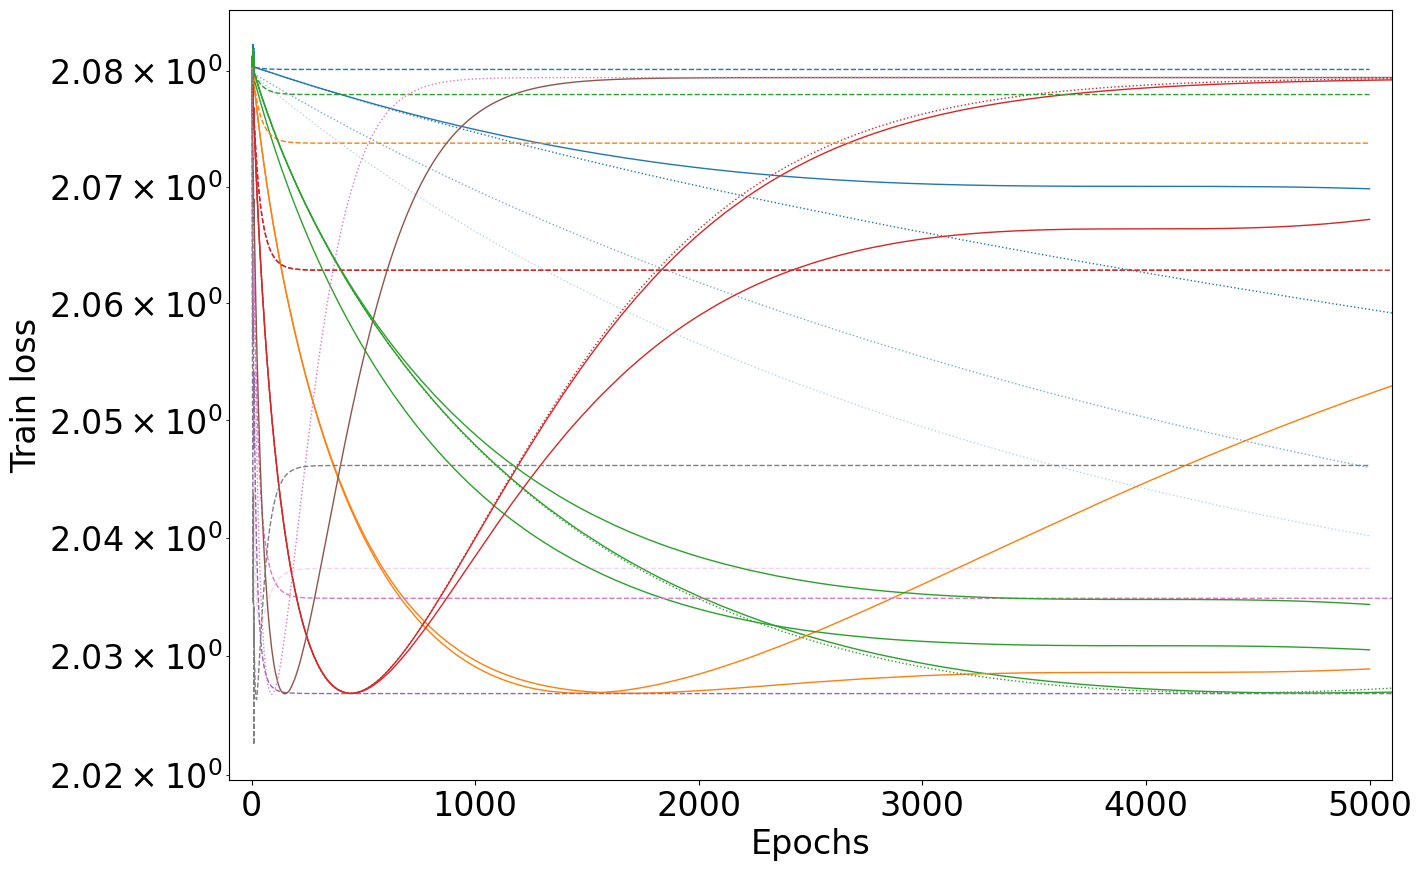

In [25]:
f, a = plot_all_train_losses(decs, col_fun=dec_lr_cols, smooth=3, legend=False)
a.set_xlim(-100, 5100)

(-100.0, 5100.0)

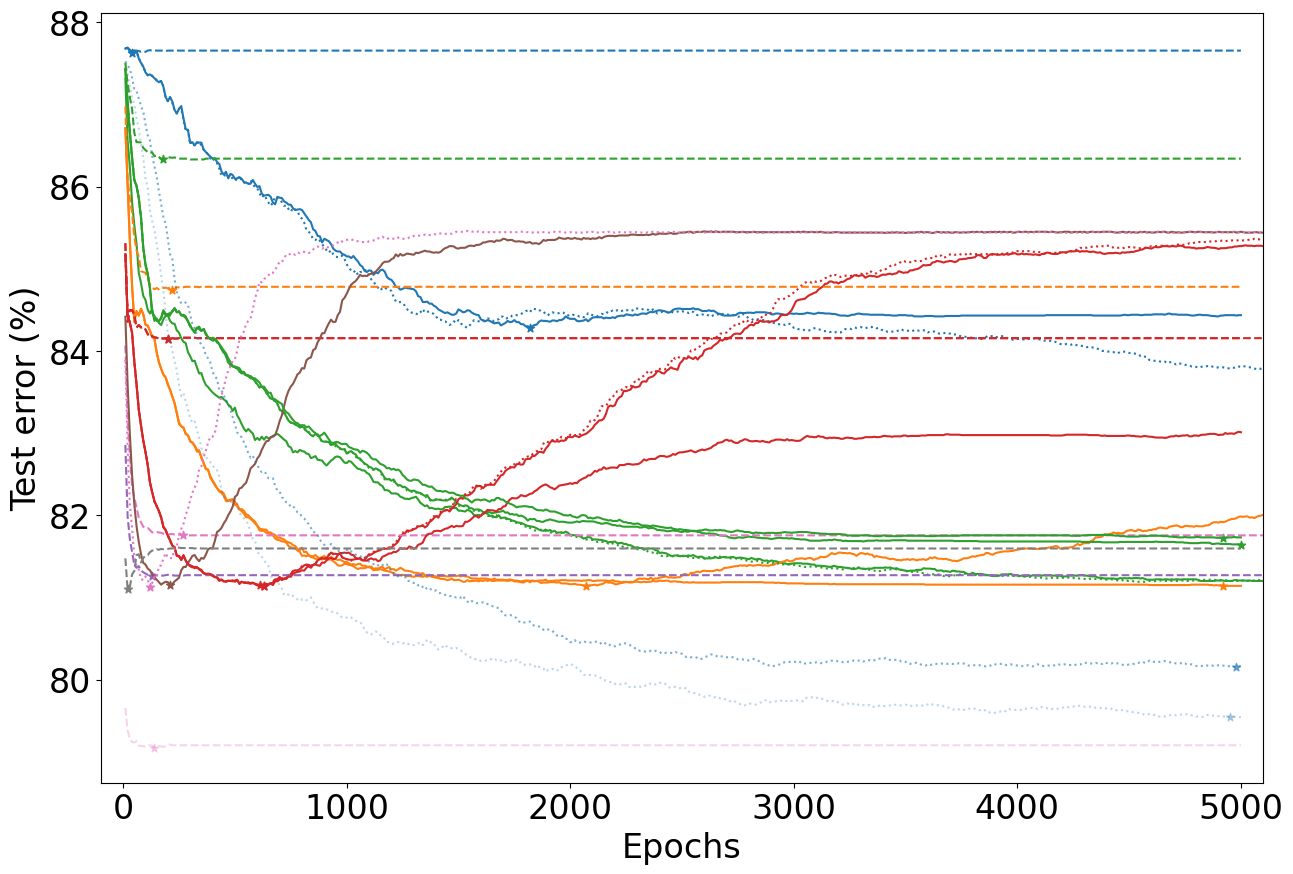

In [26]:
f, a = plot_all_test_errors(decs, col_fun=dec_lr_cols, legend=False)
a.set_xlim(-100, 5100)

In [27]:
best_decs = decs[decs.best_acc > 19]
len(best_decs)

3

In [23]:
compare_rows(decs).sort_values("best_acc")

,Unnamed: 0,name,best_acc,ptr,scheduler,lr,epochs,zero_loss_epochs,zero_loss_threshold,layerwise
34,34,clapp_loss_3_4_clfe_6,12.370,2048,exponential,0.001,5000,10,0.002,0
39,39,clapp_loss_3_4_clfe_4,13.670,2048,exponential,0.010,5000,10,0.002,0
26,26,clapp_loss_3_4_clfe_2,15.255,2048,exponential,0.030,5000,10,0.002,0
15,15,clapp_loss_3_4_clfe_7,15.720,2048,cosineannealing,0.001,5000,10,0.002,0
6,6,clapp_loss_3_4_clfe_0,15.855,2048,exponential,0.100,5000,10,0.002,0
10,10,clapp_loss_3_4_clfe_8,15.855,2048,exponential,0.100,20000,10,0.002,0
28,28,clapp_loss_3_4_clfe_9,18.245,2048,exponential,0.500,20000,10,0.002,0
3,3,clapp_loss_3_4_clfe_18,18.275,2048,none,0.001,20000,10,0.002,0
36,36,clapp_loss_3_4_clfe_5,18.280,2048,cosineannealing,0.010,5000,10,0.002,0
14,14,clapp_loss_3_4_clf,18.365,2048,cosineannealing,0.010,5000,5,0.020,1


## Masking

In [ ]:
### Supposes having loaded logs/mask/


## Sequential learning

In [8]:
### Supposes having loaded logs/seq
def setup_colors_seq(df):
    colormap = mpl.colormaps["tab20"]
    col_dict = {run: colormap(i%20) for i, run in enumerate(df.encoder_run.unique())}
    def col_fun(row):
        try:
            c = col_dict[row.encoder_run]
        except KeyError:
            print("Could not find color for", row, "(", row.encoder_run, ")")
            c = "k"
        if "layer" in row and row.layer == -1:
            a = 0.4
        else:
            a = 1
        mln = (row.m, row.num_layers, row.num_features)
        if mln == (2,2,4):
            ls = "-"
        elif mln == (3,4,5):
            ls = "--"
        elif mln == (6,3,8):
            ls = ":"
        else:
            ls = "-."
        return c, a, ls
    return col_fun


def plot_loss_for_seq(df, col_fun, shift=0.005, smooth=20, max_layers=4):
    fig, axs = plt.subplots(1, max_layers, figsize=(16,7), sharex=True, sharey=True)
    j = 0
    for i, row in df.iterrows():
        if row.layer < 0:
            i_plot = 0
        else:
            i_plot = row.layer
        c, a, ls = col_fun(row)
        axs[i_plot].plot(row.epochs_lst, smoothen(row.train_loss, width=smooth)+j*shift,
                         label=row.encoder_run, alpha=a, ls=ls, c=c)
        j+=1
    axs[0].set_yscale('log')
    for ax in axs:
        ax.legend()
    return fig, axs

seq_cols = setup_colors_seq(clapp_runs)

(-50.0, 1550.0)

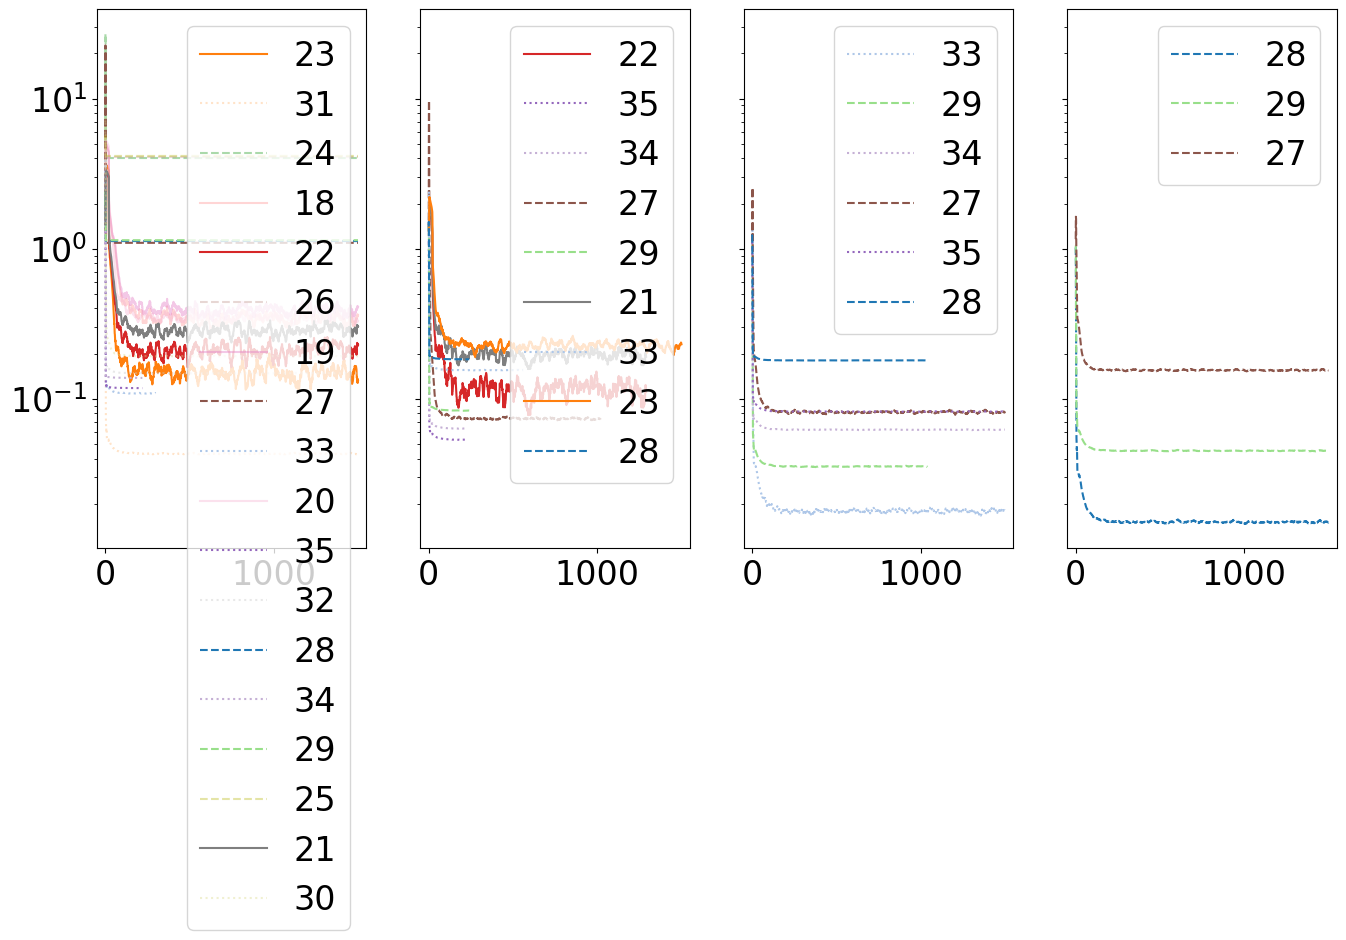

In [9]:
fig, axs = plot_loss_for_seq(clapp_runs, seq_cols, max_layers=4, smooth=20)
axs[0].set_xlim(-50, 1550)

(<Figure size 1500x1000 with 1 Axes>,
 <Axes: xlabel='Epochs', ylabel='Train loss'>)

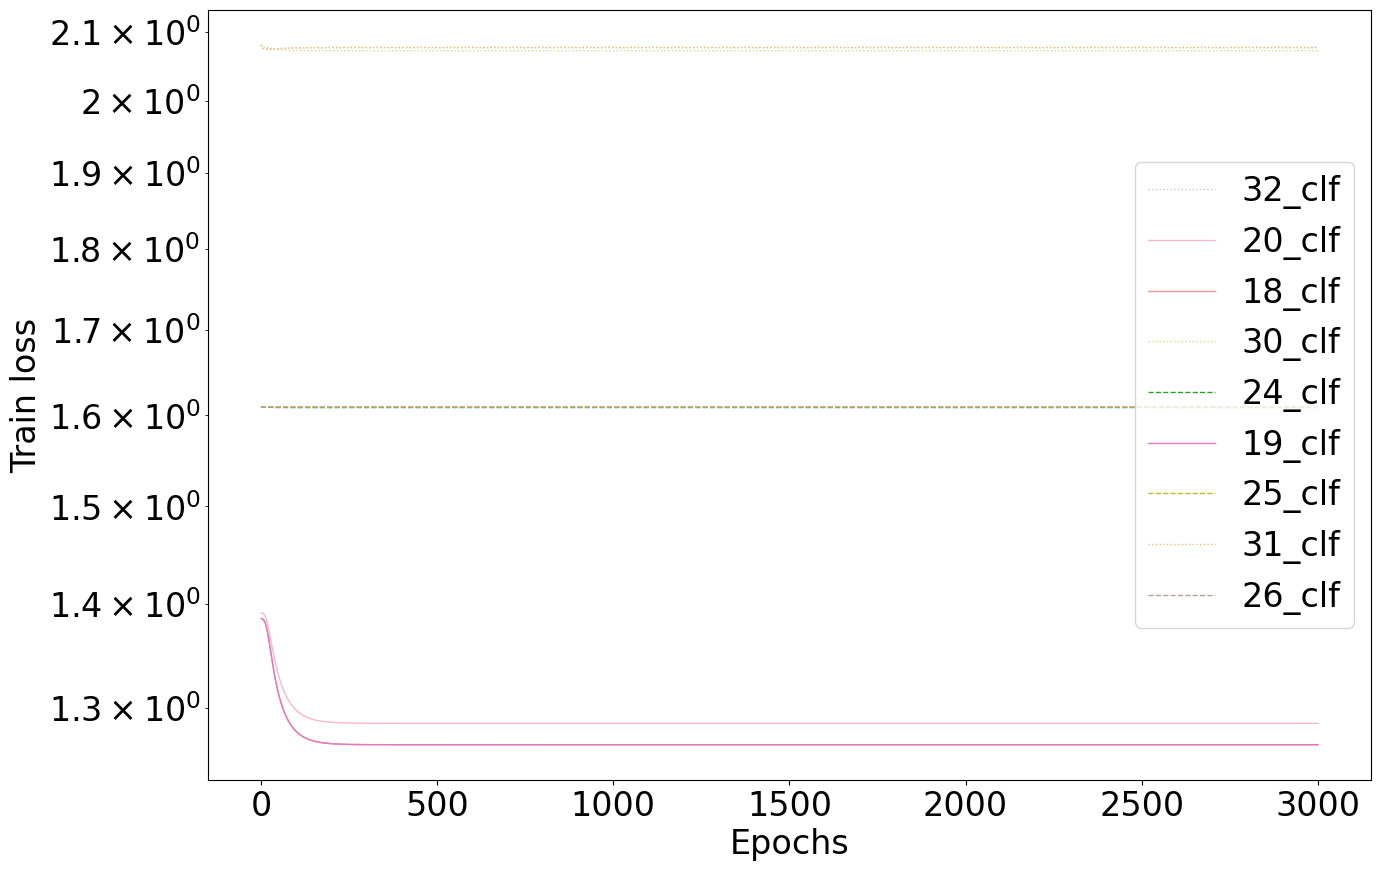

In [10]:
plot_all_train_losses(clapp_evals, col_fun=seq_cols)

(<Figure size 1500x1000 with 1 Axes>,
 <Axes: xlabel='Epochs', ylabel='Test error (%)'>)

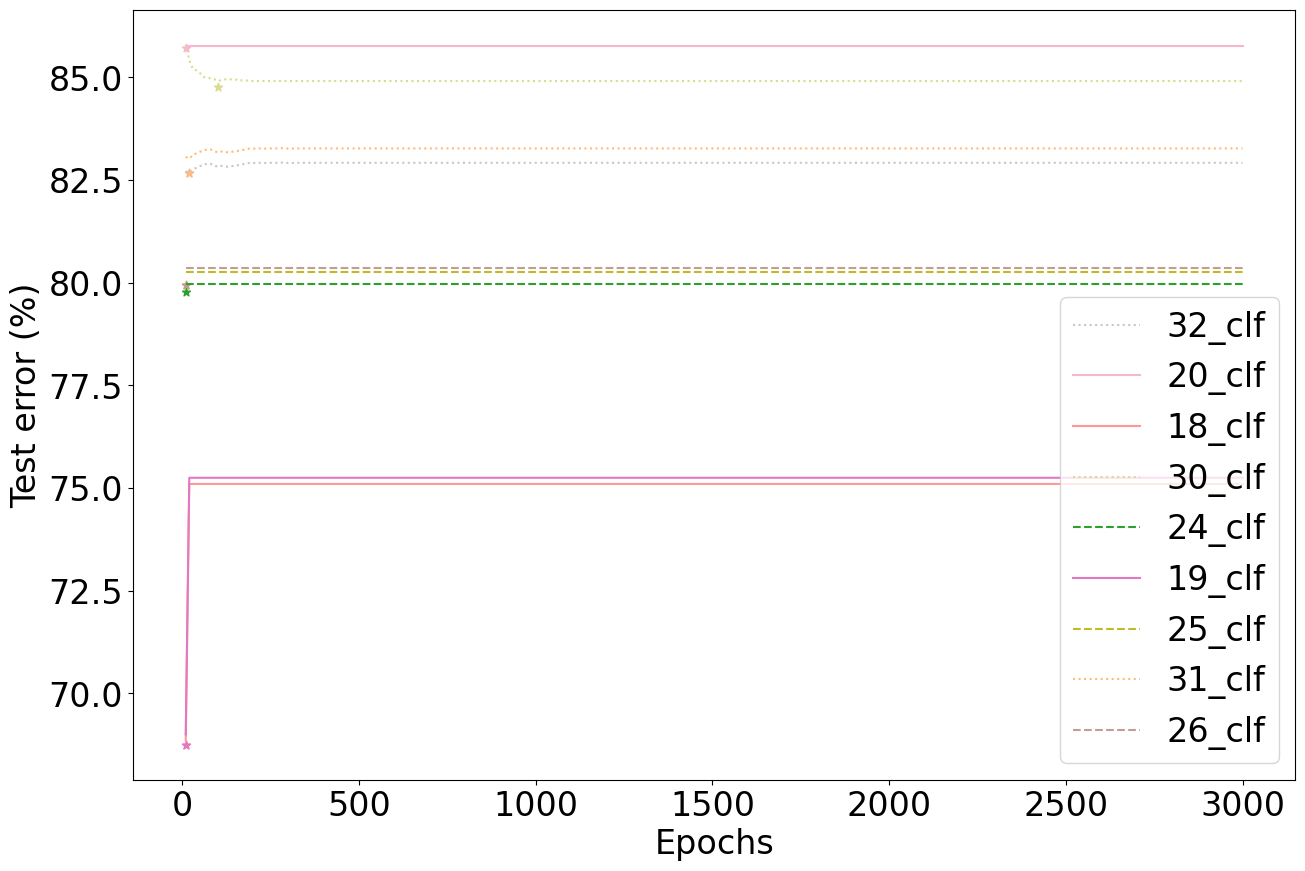

In [13]:
plot_all_test_errors(clapp_evals, col_fun=seq_cols, shift=0.05)

## Random masking

In [9]:
## Supposes having loaded logs/rd
def setup_cols_rd(df):
    lr_dct = {0.1: 1, 0.01: 0.7, 0.001: 0.4, 0.0001: 0.1}
    ptr_dct = {x: f"C{i%10}" for i, x in enumerate(df.ptr.unique())}
    all_dct = {}
    for _, row in df.iterrows():
        mln = (row.m, row.num_layers, row.num_features)
        if row.random_pred and mln == (6,3,8):
            ls = "--"
        elif mln == (6,3,8):
            ls = "-"
        elif row.random_pred and mln == (2,4,4):
            ls = ":"
        elif mln == (2,4,4):
            ls = "-."
        a = lr_dct[row.lr]
        c = ptr_dct[row.ptr]
        all_dct[row.encoder_run] = (c, a, ls)
    def rd_col(row):
        return all_dct[row.encoder_run]
    return rd_col

(<Figure size 1500x1000 with 1 Axes>,
 <Axes: xlabel='Epochs', ylabel='Train loss'>)

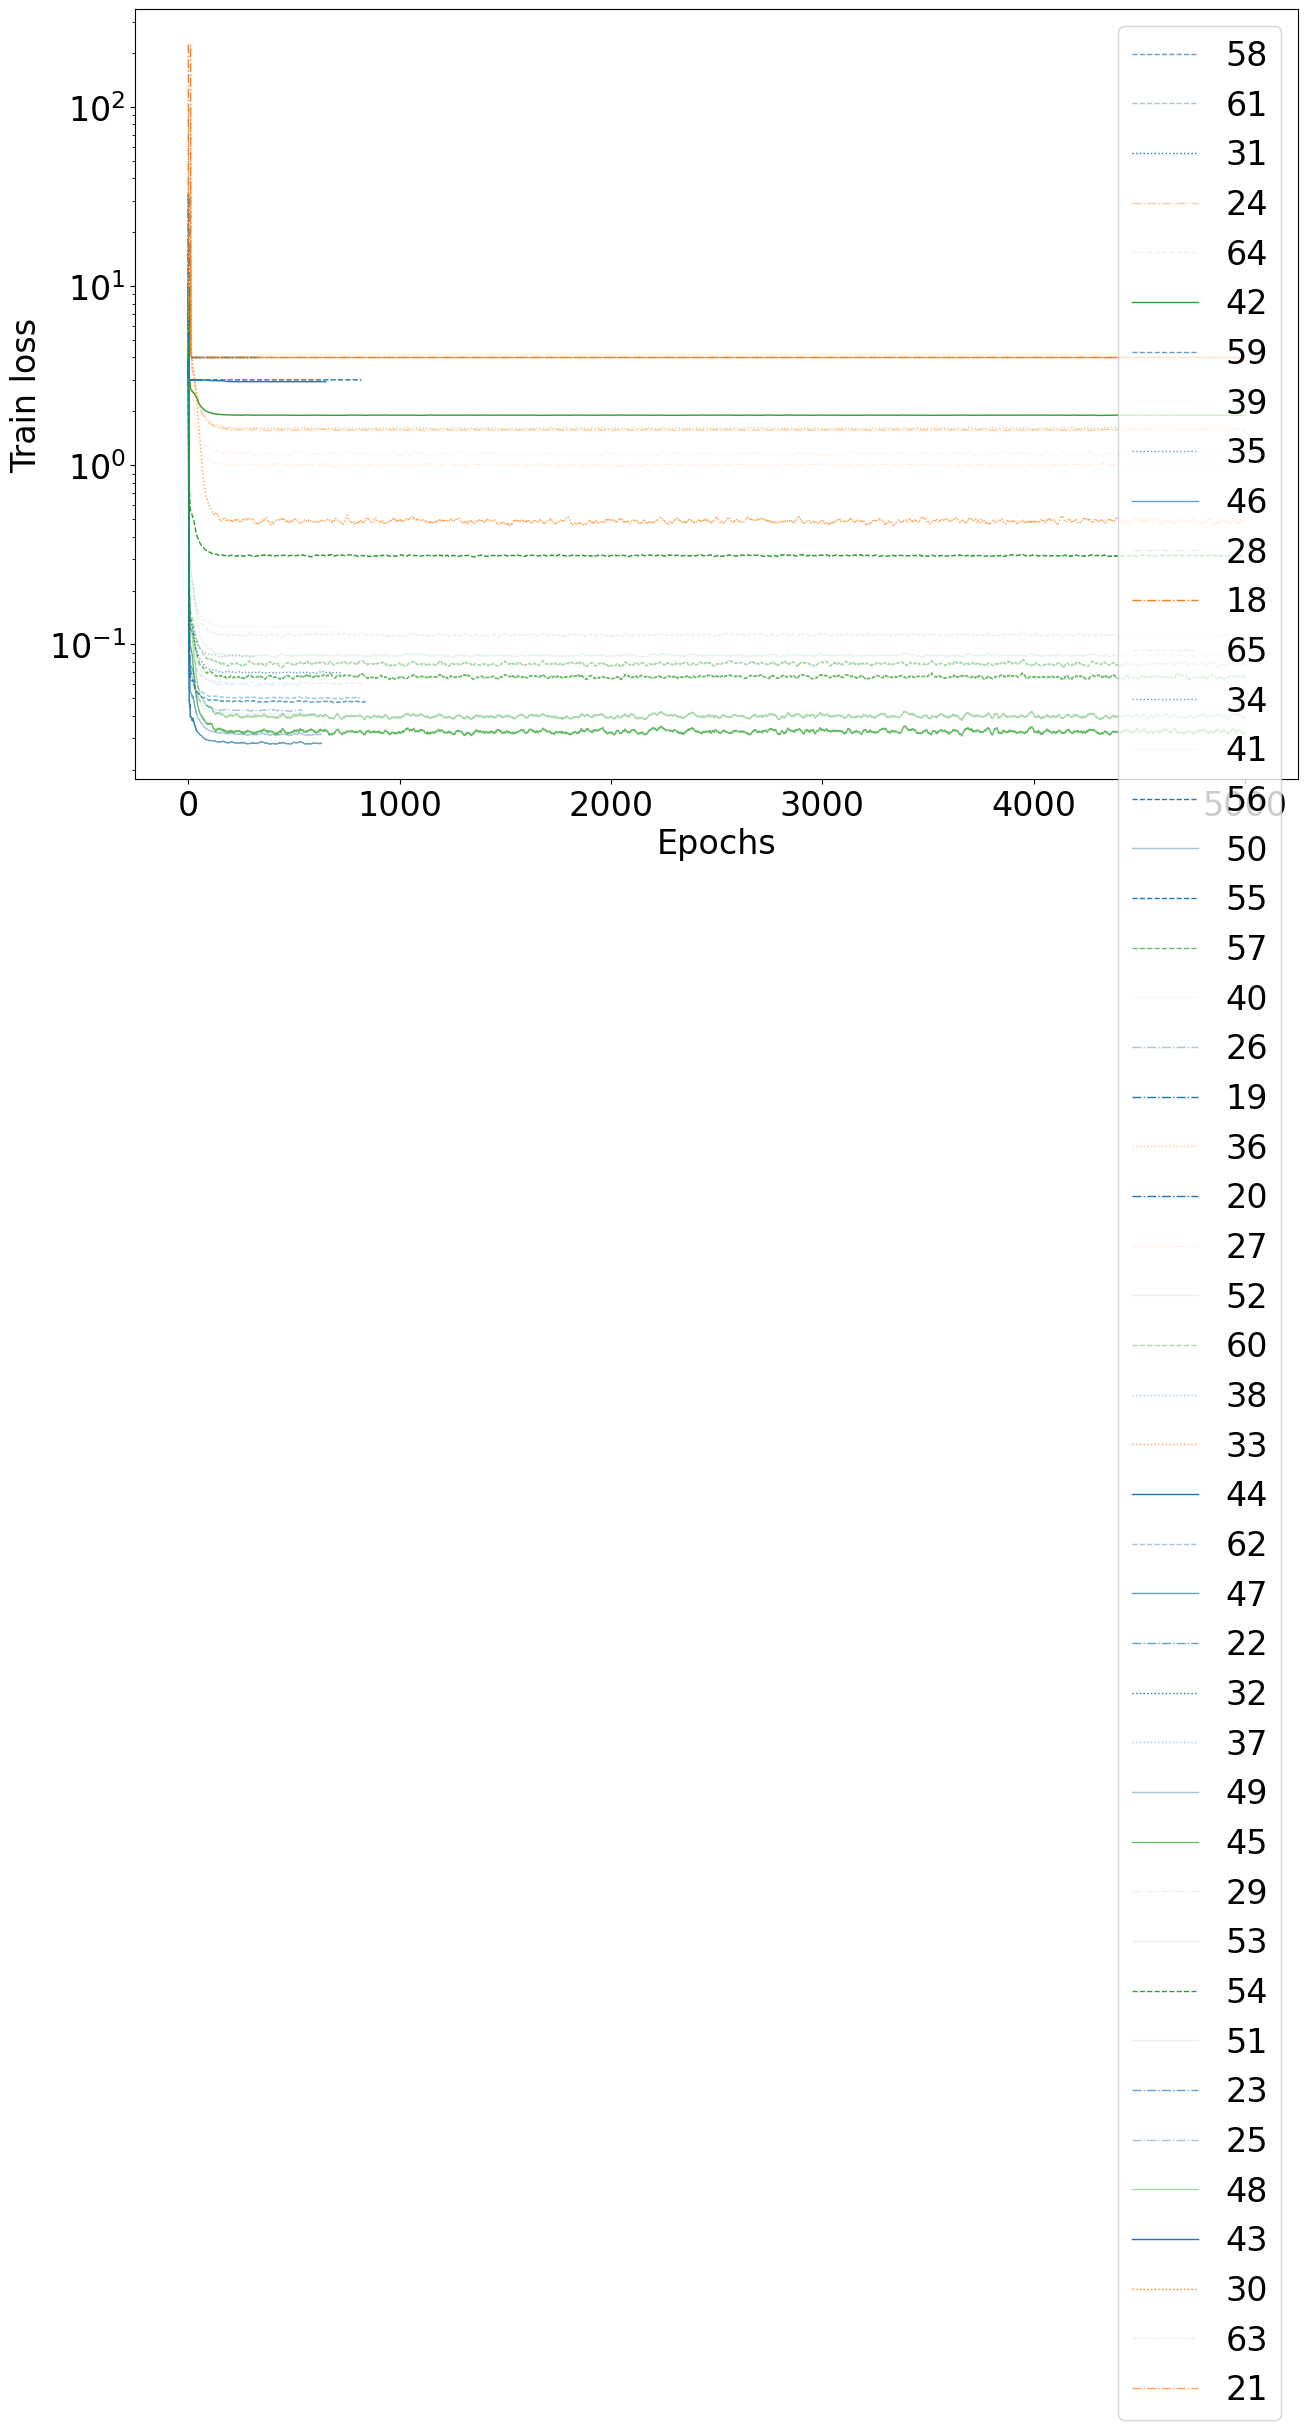

In [10]:
rd_col = setup_cols_rd(clapp_runs)
plot_all_train_losses(clapp_runs, col_fun=rd_col, )

(<Figure size 1500x1000 with 1 Axes>,
 <Axes: xlabel='Epochs', ylabel='Train loss'>)

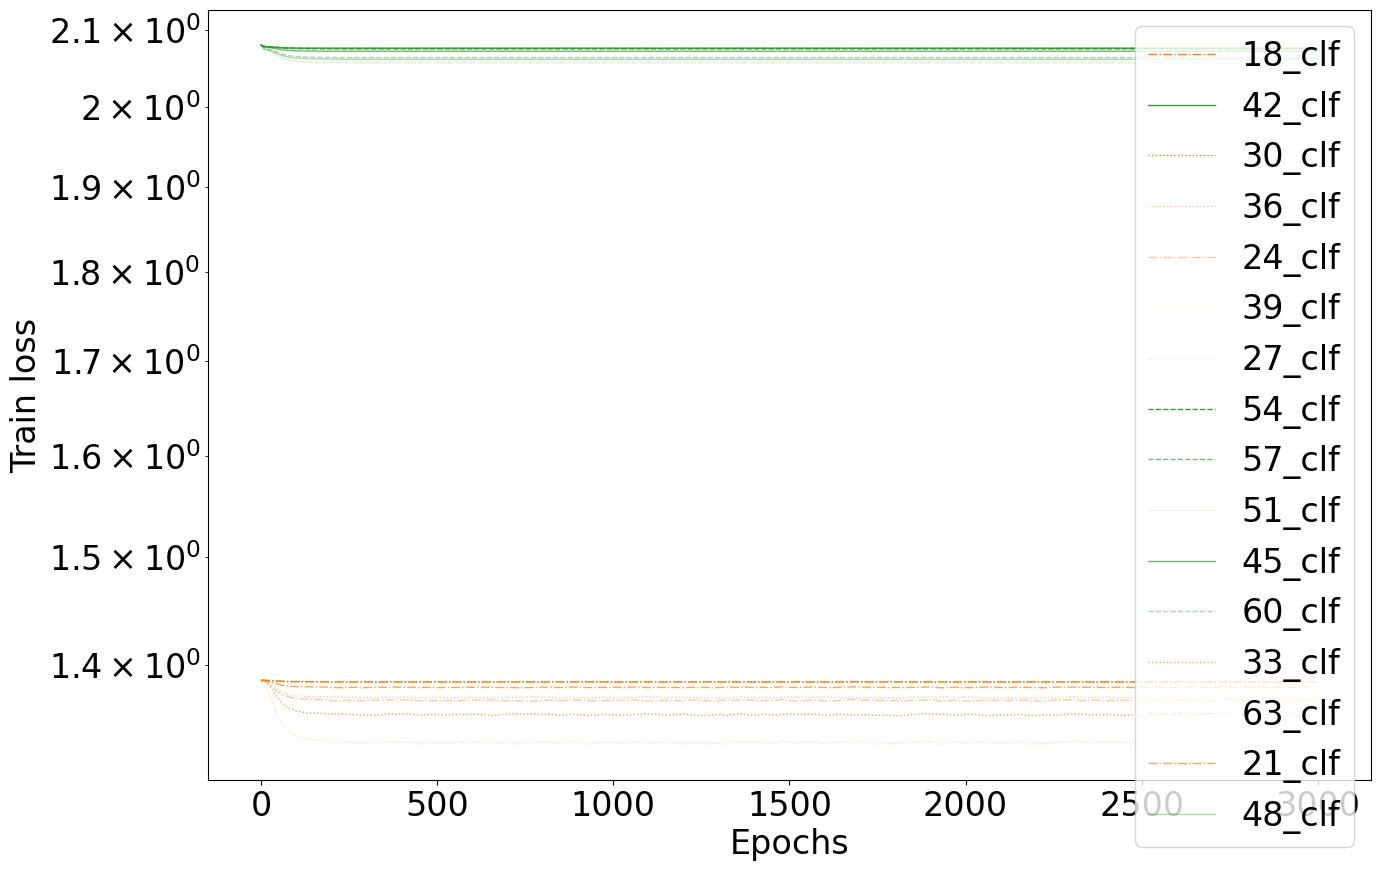

In [11]:
plot_all_train_losses(clapp_evals, col_fun=rd_col, smooth=40)

(<Figure size 1500x1000 with 1 Axes>,
 <Axes: xlabel='Epochs', ylabel='Test error (%)'>)

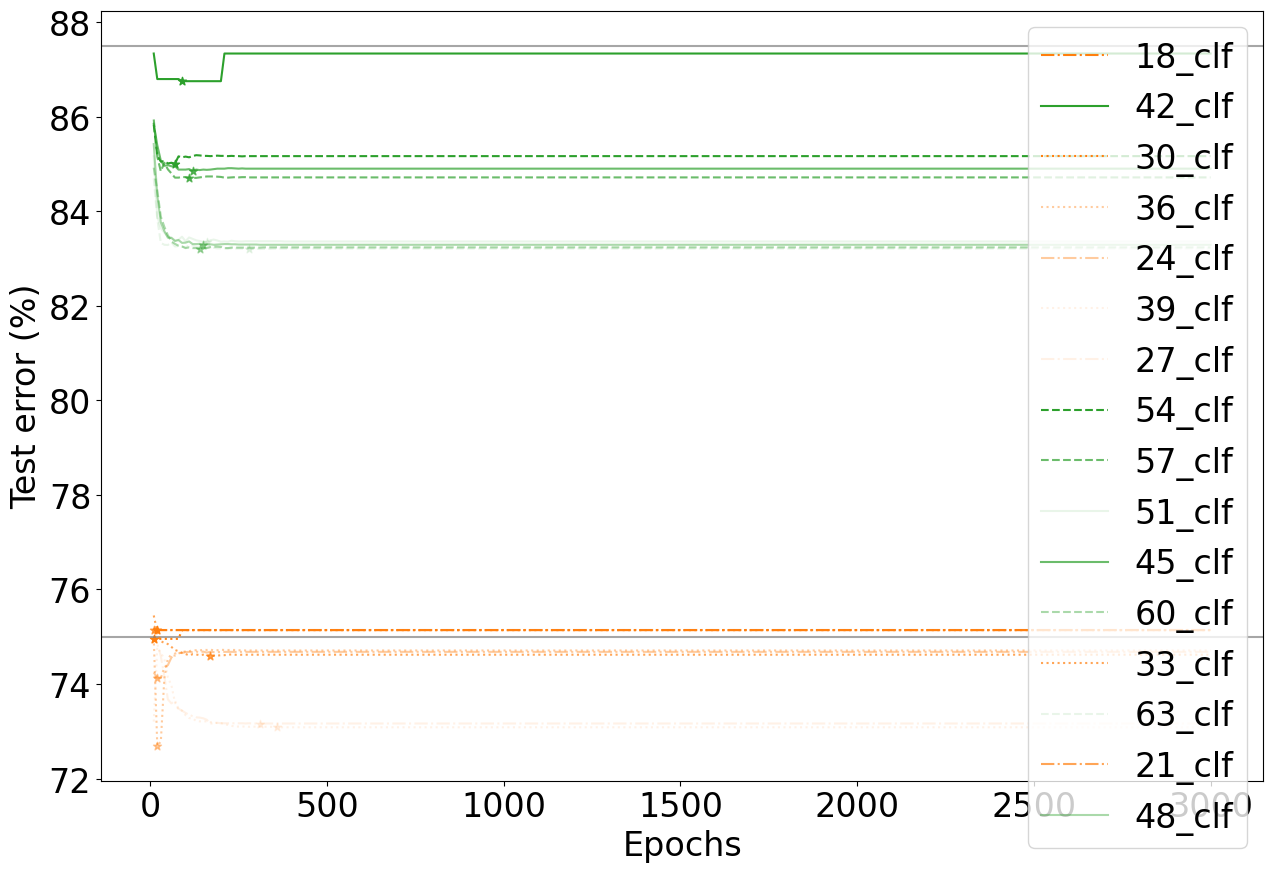

In [12]:
plot_all_test_errors(clapp_evals, col_fun=rd_col)